# Investigating the Relation of the Various Factors on Covid-19 Contraction Rates

## Summer 2024 Data Science Project

### Group Members: Alexander Csontos, Andre Achee, Joshua Kuhn, Samuel Heman-Ackha III

### **INTRODUCTION**
The Covid-19 virus first emerged in December 2019 in the city of Wuhan, China as an atypical virus that did not respond to known treatments. The World Health Organization (WHO) classified the widespread outbreak of the virus as a global pandemic in March 2020. This classification followed after the confirmation of 118,000 cases amongst 114 countries as well as a death toll of 4,291.

By May 28 2020, the US death toll surpassed 100,000, by June 10, 2020 the number of confirmed cases in the US surpassed 2,000,000. Only 6 months after being declared a global pandemic, Covid-19 became the 3rd leading cause of death in the US.

In this project, we aim to investigate the effectiveness of the vaccine in mitigating the contraction rates of Covid-19 as well as to look into whether various factors such as GDP per capita and gender have any correlation to contraction rates. This is important as the impact Covid-19 had been seen to hold worldwide during its peak was devestating worldwide and was the cause of many fatalities as well as reductions in global productivity. By investigating the impact of the vaccine's efficacy as well as varying factors' impact on contraction rates, we can come to a conclusion that confirms or denies that the vaccine mitgated the spread of the virus as well as if these external factors hold any correlation to the contraction of the virus.



### **DATA CURATION**

Information regarding is primarily gathered from the CDC and WHO.

https://www.cdc.gov/museum/timeline/covid19.html

https://data.cdc.gov/Public-Health-Surveillance/Rates-of-COVID-19-Cases-or-Deaths-by-Age-Group-and/d6p8-wqjm/about_data

https://covid19.who.int/WHO-COVID-19-global-data.csv



Import the necessary libraries

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler


**Import the dataframes**

In [30]:
WHO_df = pd.read_csv('WHO-COVID-19-global-data.csv', delimiter = ',')
econ_df = pd.read_csv('economy.csv', delimiter = ',')
covid_rates_df = pd.read_csv('Rates_of_COVID-19_Cases_or_Deaths_by_Age_Group_and_Vaccination_Status_and_Booster_Dose_20240622.csv', delimiter = ',')
covid_sex_df = pd.read_csv('by-sex.csv', delimiter = ',')

Before any of the dataframes can be used for analysis, each of the sets must be cleaned. This would include filling empty values wherever possible, discarding unhelpful features, formatting the dates correctly, and rearranging the dataframes if needed. This is necessary to get an accurate read of a pattern/correlation.

**Economy Data Cleaning**

In [31]:
#Inputting with median instead of mean due to outliers
econ_df.human_capital_index.fillna(econ_df['human_capital_index'].median(), inplace = True)
scaler = StandardScaler()
#scaling the gdp for
econ_df['gdp_usd_standard'] = scaler.fit_transform(econ_df[['gdp_usd']])
econ_df['gdp_capita_standard'] = scaler.fit_transform(econ_df[['gdp_per_capita_usd']])
#drop any duplicates
econ_df.drop_duplicates(inplace = True)
econ_df = econ_df.rename(columns = {'location_key': 'Country_code'})

#cleaned
econ_df.head()

,Country_code,gdp_usd,gdp_per_capita_usd,human_capital_index,gdp_usd_standard,gdp_capita_standard
0,AD,3.154058e+09,40886.0,0.567,-0.288922,0.058203
1,AE,4.211423e+11,43103.0,0.659,-0.053334,0.075120
2,AF,1.910135e+10,502.0,0.389,-0.279934,-0.249943
3,AG,1.727759e+09,17790.0,0.567,-0.289726,-0.118029
4,AL,1.527808e+10,5352.0,0.621,-0.282089,-0.212935


Under gdp_usd we see there is a high variability with a larger STD, showing the dataframe that is used contained very small countries with low GDP, and larger countries with a very high GDP in comparison.

**WHO Data Cleaning**

In [32]:
# Create dictionaries for country codes and  regions based on the good data
country_code_dict = WHO_df.dropna(subset=['Country_code']).set_index('Country')['Country_code'].to_dict()
who_region_dict = WHO_df.dropna(subset=['WHO_region']).set_index('Country')['WHO_region'].to_dict()

# Fill missing values for the bad data on both
WHO_df['Country_code'] = WHO_df['Country_code'].fillna(WHO_df['Country'].map(country_code_dict))
WHO_df['WHO_region'] = WHO_df['WHO_region'].fillna(WHO_df['Country'].map(who_region_dict))

# Manually fill in the missing values for specific countries
manual_fill = {
    'Namibia': {'Country_code': 'NA', 'WHO_region': 'AFRO'},
    'Falkland Islands (Malvinas)': {'Country_code': 'FK', 'WHO_region': 'AMRO'},
    'Faroe Islands': {'Country_code': 'FO', 'WHO_region': 'EURO'},
    'French Guiana': {'Country_code': 'GF', 'WHO_region': 'AMRO'},
    'Gibraltar': {'Country_code': 'GI', 'WHO_region': 'EURO'},
    'Guadeloupe': {'Country_code': 'GP', 'WHO_region': 'AMRO'},
    'Guernsey': {'Country_code': 'GG', 'WHO_region': 'EURO'},
    'Holy See': {'Country_code': 'VA', 'WHO_region': 'EURO'},
    'Isle of Man': {'Country_code': 'IM', 'WHO_region': 'EURO'},
    'Jersey': {'Country_code': 'JE', 'WHO_region': 'EURO'},
    'Liechtenstein': {'Country_code': 'LI', 'WHO_region': 'EURO'},
    'Martinique': {'Country_code': 'MQ', 'WHO_region': 'AMRO'},
    'Mayotte': {'Country_code': 'YT', 'WHO_region': 'AFRO'},
    'Pitcairn': {'Country_code': 'PN', 'WHO_region': 'WPRO'},
    'Réunion': {'Country_code': 'RE', 'WHO_region': 'AFRO'},
    'Saint Barthélemy': {'Country_code': 'BL', 'WHO_region': 'AMRO'},
    'Saint Helena': {'Country_code': 'SH', 'WHO_region': 'AFRO'},
    'Saint Martin (French part)': {'Country_code': 'MF', 'WHO_region': 'AMRO'},
    'Saint Pierre and Miquelon': {'Country_code': 'PM', 'WHO_region': 'AMRO'}
}

for country, values in manual_fill.items():
    WHO_df.loc[WHO_df['Country'] == country, 'Country_code'] = values['Country_code']
    WHO_df.loc[WHO_df['Country'] == country, 'WHO_region'] = values['WHO_region']

# replace missing values with 0's
WHO_df['New_cases'] = WHO_df['New_cases'].fillna(0)
WHO_df['New_deaths'] = WHO_df['New_deaths'].fillna(0)

# Convert Date reported to datetime
WHO_df['Date_reported'] = pd.to_datetime(WHO_df['Date_reported'])

# Making sure columns have the right data type
WHO_df['New_cases'] = WHO_df['New_cases'].astype(int)
WHO_df['Cumulative_cases'] = WHO_df['Cumulative_cases'].astype(int)
WHO_df['New_deaths'] = WHO_df['New_deaths'].astype(int)
WHO_df['Cumulative_deaths'] = WHO_df['Cumulative_deaths'].astype(int)

# Removing duplicate rows
WHO_df = WHO_df.drop_duplicates()

# Check for unique country names and codes just in case
unique_countries = WHO_df['Country'].unique()
unique_country_codes = WHO_df['Country_code'].unique()
unique_who_regions = WHO_df['WHO_region'].unique()

#cleaned
WHO_df

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-12,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-19,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-26,AF,Afghanistan,EMRO,0,0,0,0
4,2020-02-02,AF,Afghanistan,EMRO,0,0,0,0
...,...,...,...,...,...,...,...,...
55675,2024-05-12,ZW,Zimbabwe,AFRO,0,266365,0,5740
55676,2024-05-19,ZW,Zimbabwe,AFRO,0,266365,0,5740
55677,2024-05-26,ZW,Zimbabwe,AFRO,0,266365,0,5740
55678,2024-06-02,ZW,Zimbabwe,AFRO,0,266365,0,5740


**Covid by Sex Data Cleaning**

In [33]:
#converting date format to datetime, cleaning the data by converting invalid dates to NaT
covid_sex_df['date'] = pd.to_datetime(covid_sex_df['date'], errors = 'coerce')
# Drop rows with NaT (where the datetime conversion failed)
covid_sex_df = covid_sex_df.dropna(subset = ['date'])

# filtering the dataframe to consist of only dates from December 2019 to present
# because first case of COVID-19 was in December 2019 according to NIH
filtered_sex_df = covid_sex_df[covid_sex_df['date'] >= '2019-12-01']

# assigning a list of the columns we would like to keep
columns_to_keep = ['date','location_key',
       'cumulative_confirmed_male', 'cumulative_confirmed_female',
       'cumulative_deceased_male',
       'cumulative_deceased_female', 'cumulative_recovered_male',
       'cumulative_recovered_female',
       'cumulative_tested_male', 'cumulative_tested_female',
       'cumulative_hospitalized_patients_male',
       'cumulative_hospitalized_patients_female',
       'cumulative_intensive_care_patients_male',
       'cumulative_intensive_care_patients_female']

#further cleaning the dataframe to consist of only relevant cumulative counts
covid_sex_df = filtered_sex_df[columns_to_keep].copy()

#ensuring that the filtering was successful
# covid_sex_df.columns

# forward filling NaN values in entire dataframe since data is cumulative
covid_sex_df.fillna(method = 'ffill', inplace = True)

#cleaned
covid_sex_df

<ipython-input-33-095ade46f6b3>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_sex_df['date'] = pd.to_datetime(covid_sex_df['date'], errors = 'coerce')


,date,location_key,cumulative_confirmed_male,cumulative_confirmed_female,cumulative_deceased_male,cumulative_deceased_female,cumulative_recovered_male,cumulative_recovered_female,cumulative_tested_male,cumulative_tested_female,cumulative_hospitalized_patients_male,cumulative_hospitalized_patients_female,cumulative_intensive_care_patients_male,cumulative_intensive_care_patients_female
63,2019-12-09,AR,16.0,16.0,0.0,0.0,NaN,NaN,77.0,86.0,0.0,0.0,1.0,1.0
64,2019-12-19,AR,16.0,16.0,0.0,0.0,NaN,NaN,77.0,86.0,0.0,0.0,2.0,1.0
65,2019-12-20,AR,16.0,16.0,0.0,0.0,NaN,NaN,79.0,86.0,0.0,0.0,2.0,1.0
66,2019-12-21,AR,16.0,16.0,0.0,0.0,NaN,NaN,80.0,87.0,0.0,0.0,2.0,1.0
67,2019-12-22,AR,16.0,16.0,0.0,0.0,NaN,NaN,81.0,87.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3848335,2020-08-07,US_MA,52978.0,65464.0,1120.0,1090.0,407.0,460.0,411019.0,490393.0,179.0,186.0,3318.0,1471.0
3848336,2020-08-08,US_MA,53153.0,65687.0,1120.0,1090.0,407.0,460.0,411019.0,490393.0,179.0,186.0,3318.0,1471.0
3848337,2020-08-09,US_MA,53316.0,65851.0,1120.0,1090.0,407.0,460.0,411019.0,490393.0,179.0,186.0,3318.0,1471.0
3848338,2020-08-10,US_MA,53445.0,65989.0,1120.0,1090.0,407.0,460.0,411019.0,490393.0,179.0,186.0,3318.0,1471.0


**Covid Rates Data Cleaning**

In [34]:
# remove all the population and age adjusted information (only need rates of cases)
# NOTE: ir = incidence rate, irr = incidence rate ratio
# crude_booster_irr is the ratio - unvaccinated:booster + primary
# crude_irr is the ratio - unvaccinated:primary vaccines only
covid_rates_df = covid_rates_df[['outcome', 'month', 'age_group', 'crude_booster_ir',
            'crude_primary_series_only_ir', 'crude_unvax_ir', 'crude_booster_irr', 'crude_irr']]

# convert month to datetime
covid_rates_df['month'] = pd.to_datetime(covid_rates_df['month'], errors = 'coerce')

# fill the Na values in each column with the mean of their corresponding age group
def fillna_mean(df, column):
    df[column] = df[column].fillna(df.groupby('age_group')[column].transform('mean'))

fillna_mean(covid_rates_df, 'crude_booster_ir')
fillna_mean(covid_rates_df, 'crude_primary_series_only_ir')
fillna_mean(covid_rates_df, 'crude_unvax_ir')
fillna_mean(covid_rates_df, 'crude_booster_irr')
fillna_mean(covid_rates_df, 'crude_irr')

#cleaned
covid_rates_df.head()

<ipython-input-34-98a98fa7cfc6>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_rates_df['month'] = pd.to_datetime(covid_rates_df['month'], errors = 'coerce')
<ipython-input-34-98a98fa7cfc6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_rates_df['month'] = pd.to_datetime(covid_rates_df['month'], errors = 'coerce')
<ipython-input-34-98a98fa7cfc6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

,outcome,month,age_group,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr
0,death,2022-07-01,5-11,0.000000,0.000000,0.007828,1.173076,1.122780
1,death,2022-07-01,12-17,0.000000,0.000000,0.000000,1.614756,1.840452
2,death,2022-07-01,18-49,0.043637,0.032224,0.164844,3.777616,5.115596
3,case,2021-09-01,18-49,38.731810,100.258231,486.808748,12.568706,4.855549
4,case,2021-09-01,50-64,39.009219,93.423757,477.565705,12.242381,5.111823


### **EXPLORATORY DATA ANALYSIS**

In this section, we will be focusing on exploring the data sets we just cleaned to see if we can find any trends or underlying patterns in our data.
We are going to do this by taking a look at some Null and Altenrative Hypotheses represented by $H_{0}$ and $H_{A}$ respectively and conduct hypothesis testing on each through different methods suitable for the data.

- $H_{0}$: GDP of a particular country has no effect on the amount of people who contract the Covid-19 Virus on average.

- $H_{A}$: Higher GDP correlates to lower rates of Covid-19 contraction due to greater access to healthcare and the vaccine on average..

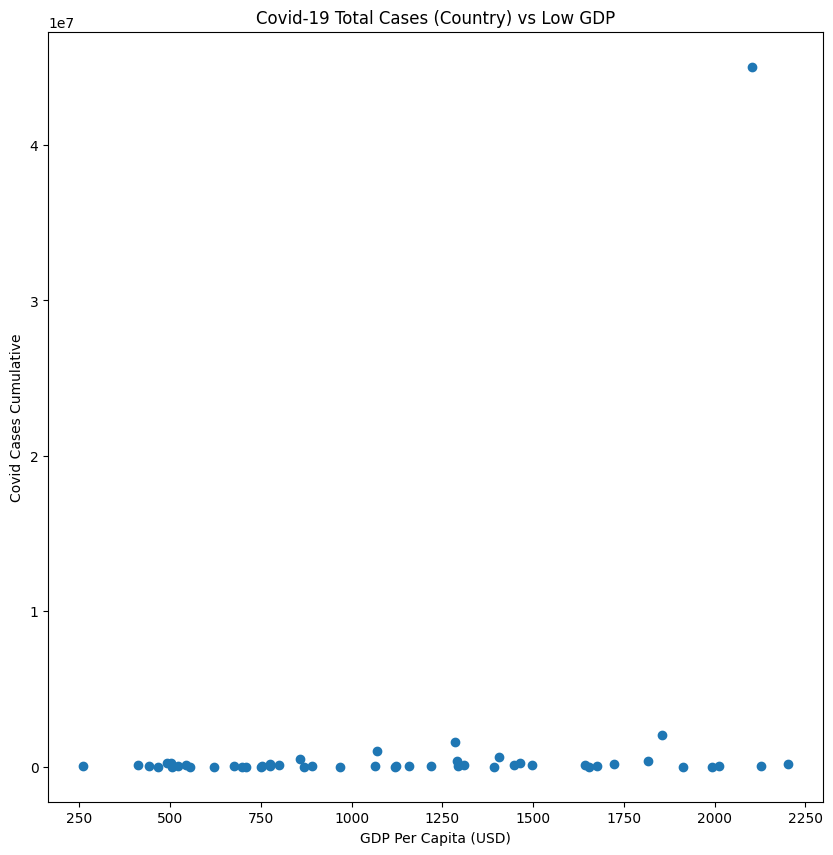

In [35]:
WHO_df
econ_df
#get the cumulative of the new_cases by country
tot_cases = WHO_df.groupby('Country_code')['New_cases'].sum().reset_index()
#Join the economy df by country code, adding the total cases by country
merged_df = pd.merge(tot_cases, econ_df, on='Country_code', how = 'inner')
merged_df = merged_df[['Country_code', 'New_cases', 'gdp_per_capita_usd']]


#seperating dataframes by percentiles of GDP, havin
low_gdp = merged_df[(merged_df['gdp_per_capita_usd'] >= 0) & (merged_df['gdp_per_capita_usd'] <= 2222.25)]
medium_gdp = merged_df[(merged_df['gdp_per_capita_usd'] > 2222.25) & (merged_df['gdp_per_capita_usd'] <= 6910)]
high_gdp = merged_df[(merged_df['gdp_per_capita_usd'] > 6910) & (merged_df['gdp_per_capita_usd'] <= 23042.25)]
very_high_gdp = merged_df[(merged_df['gdp_per_capita_usd'] > 23042.25)]
#Scatter plot to show the cases by sorted gdp
def plot_mult(df, name):
  df = df.sort_values('gdp_per_capita_usd')
  plt.figure(figsize=(10, 10))
  plt.scatter(df['gdp_per_capita_usd'], df['New_cases'])
  plt.title(name)
  plt.ylabel('Covid Cases Cumulative')
  plt.xlabel('GDP Per Capita (USD)')


plot_mult(low_gdp, 'Covid-19 Total Cases (Country) vs Low GDP')

From this plot, we can see that most of the lower GDP has a similar Covid Case Cumulative with one clear outlier from the lower GDP.

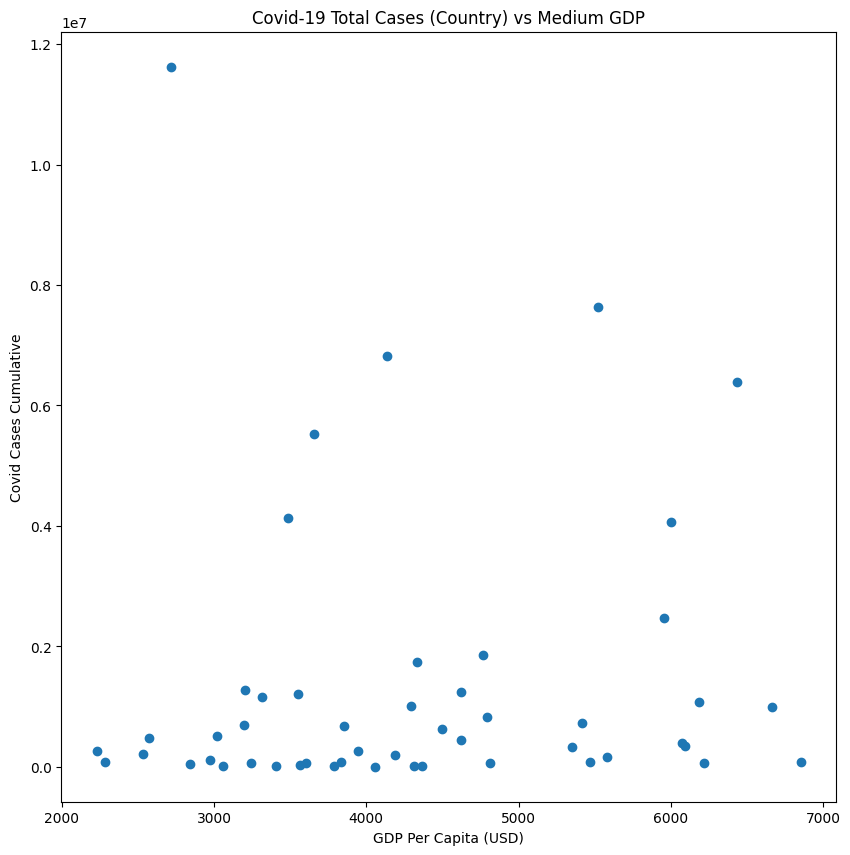

In [36]:
plot_mult(medium_gdp, 'Covid-19 Total Cases (Country) vs Medium GDP')

Here we can see that the medium GDP has a larger spread compared to before, with a few outliers to be seen.

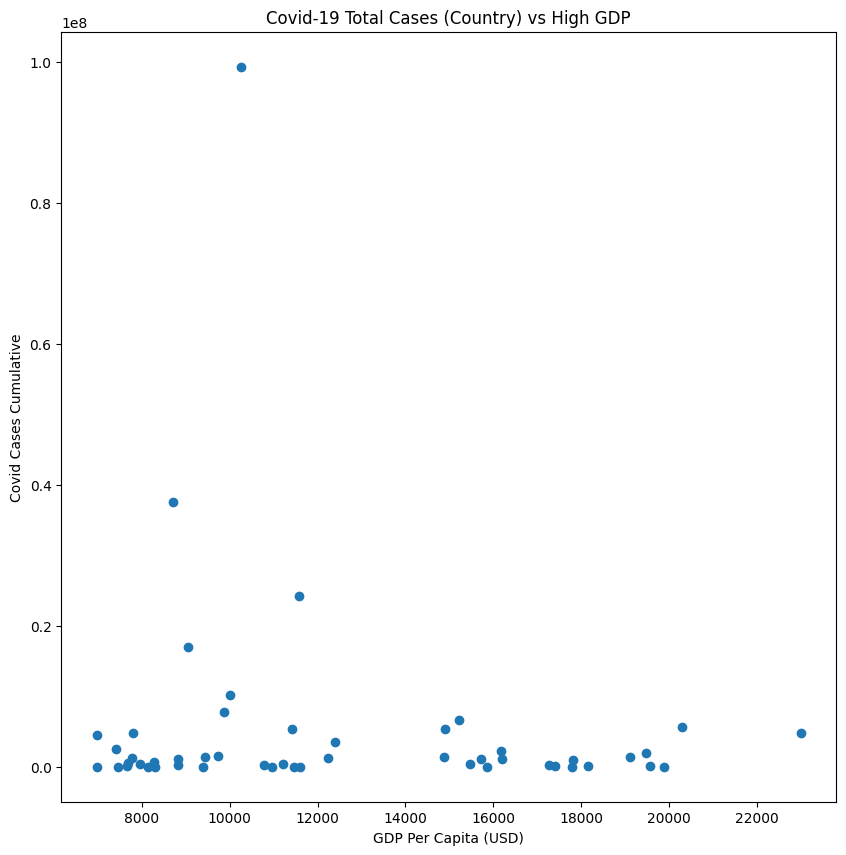

In [37]:
plot_mult(high_gdp, 'Covid-19 Total Cases (Country) vs High GDP')

High GDP shows there are higher cumulative covid cases, with less variability than the medium scatter plot, but more than the lower.

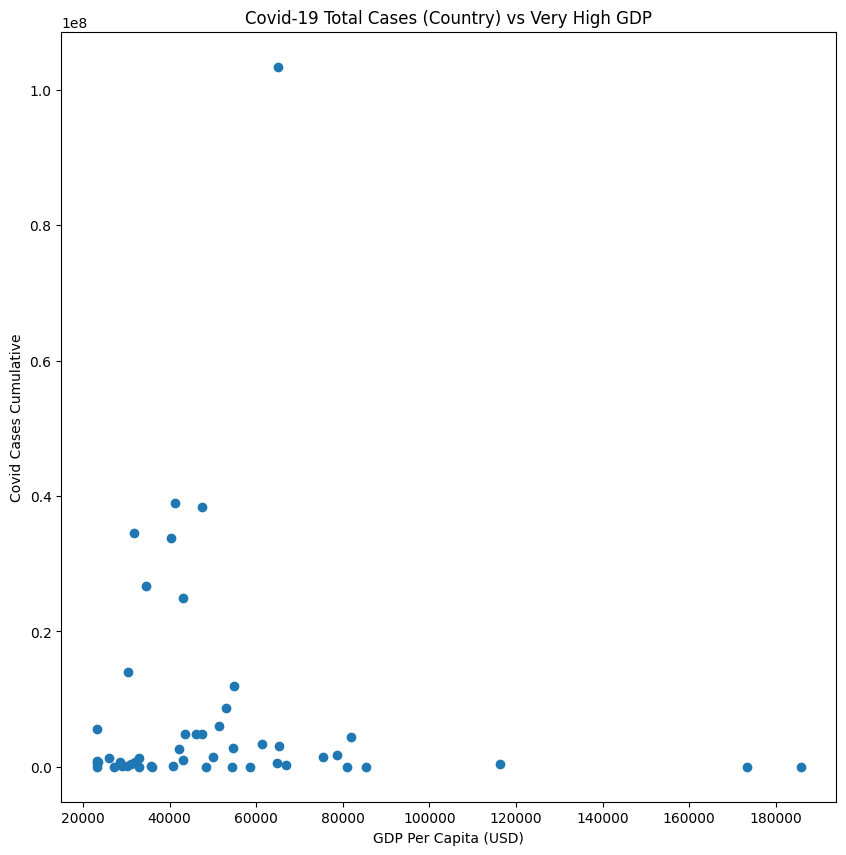

In [38]:
plot_mult(very_high_gdp, 'Covid-19 Total Cases (Country) vs Very High GDP')

The very high gdp has some outliers in GDP and one in covid cases, with a majority distributed evenly.

In [39]:
low = 2222.25
medium = 6910
high = 23042.25
#categorizing Econ data by gdp
def categorize(gdp):
  if gdp <= low:
    return 'Low'
  elif gdp <= medium:
    return 'Medium'
  elif gdp <= high:
    return 'High'
  else:
    return 'Very High'
merged_df['GDP_Category'] = merged_df['gdp_per_capita_usd'].apply(categorize)

In [40]:
gdp_per_capita = merged_df['gdp_per_capita_usd']
new_cases = merged_df['New_cases']
spearmanr(gdp_per_capita, new_cases)


SignificanceResult(statistic=0.3716342908572715, pvalue=6.024716953323579e-08)

Using a Spearman r test, as the data has a continuous and discrete data type. With a P value of 6.02e-08, which is significantly smaller than an alpha value of 0.05, we can conclude that the correlation is statistically significant and we reject the null hypothesis.

- $H_{0}$: The booster vaccine had no effect on the contraction rates of Covid-19 on average
- $H_{A}$: The booster vaccine had an effect on the contraction rates of Covid-19 on average

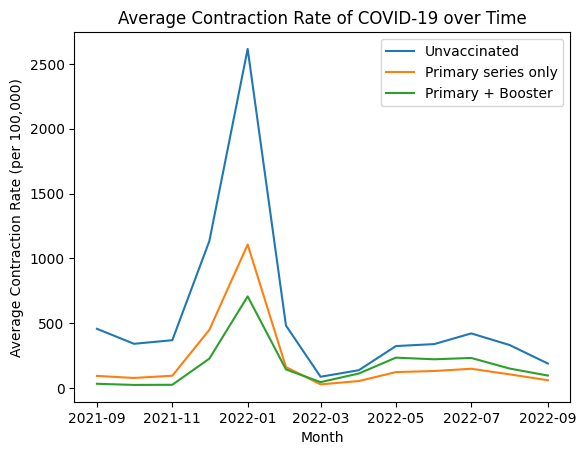

In [41]:
#drop every row where outcome = 'death'
cases_df = covid_rates_df[covid_rates_df['outcome'] != 'death']
cases_df = cases_df.drop(columns = ['outcome', 'age_group'])
cases_df = cases_df.groupby('month').mean()

#plot the average unvax_ir, primary_series_only_ir, and booster_ir over time
plt.plot(cases_df['crude_unvax_ir'], label = 'Unvaccinated')
plt.plot(cases_df['crude_primary_series_only_ir'], label = 'Primary series only')
plt.plot(cases_df['crude_booster_ir'], label = 'Primary + Booster')
plt.xlabel('Month')
plt.ylabel('Average Contraction Rate (per 100,000)')
plt.title('Average Contraction Rate of COVID-19 over Time')
plt.legend()

- $H_{0}$: Gender had an effect on the contraction rates of Covid-19 on average
- $H_{A}$: Gender had no effect on the contraction rates of Covid-19 on average

In [42]:
# grouping by 'location_key' and getting the maximum cumulative counts for each
max_counts = covid_sex_df.groupby('location_key').agg({
    'cumulative_confirmed_male': 'max',
    'cumulative_confirmed_female': 'max',
    'cumulative_tested_male': 'max',
    'cumulative_tested_female': 'max'
})

# getting actual totals for each respective category
total_cumulative_confirmed_male = max_counts['cumulative_confirmed_male'].sum()
total_cumulative_confirmed_female = max_counts['cumulative_confirmed_female'].sum()

total_cumulative_tested_male = max_counts['cumulative_tested_male'].sum()
total_cumulative_tested_female = max_counts['cumulative_tested_female'].sum()

total_cumulative_non_infected_male = total_cumulative_tested_male - total_cumulative_confirmed_male
total_cumulative_non_infected_female = total_cumulative_tested_female - total_cumulative_confirmed_female

# rows are counts of confirmed and non-infected, columns are male and female
contingency_table = [
    [total_cumulative_confirmed_male, total_cumulative_confirmed_female],  # count of males and females tested to have covid
    [total_cumulative_non_infected_male, total_cumulative_non_infected_female]  # count of males and females tested to not have covid
]

p_val = chi2_contingency(contingency_table)

print('p-value:', p_val.pvalue)

p-value: 0.0


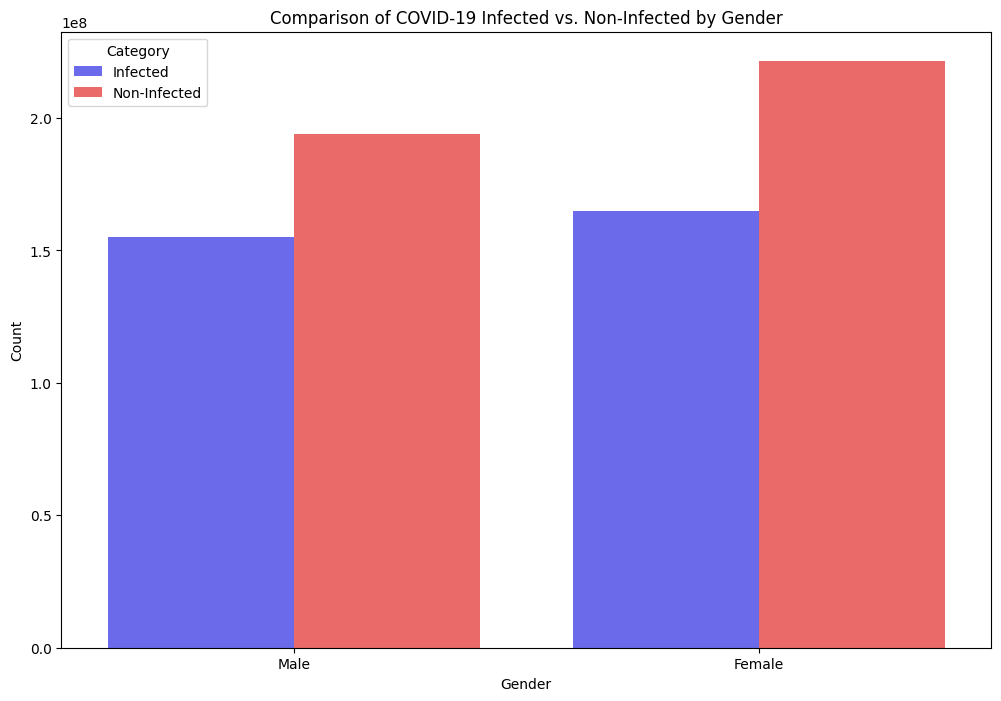

In [43]:
sex_data = {
    'Gender': ['Male', 'Male', 'Female', 'Female'],
    'Category': ['Infected', 'Non-Infected', 'Infected', 'Non-Infected'],
    'Count': [total_cumulative_confirmed_male, total_cumulative_non_infected_male,
               total_cumulative_confirmed_female, total_cumulative_non_infected_female]
}
sex_plot_df = pd.DataFrame(sex_data)

# Creating grouped bar plot to visualize data
plt.figure(figsize=(12, 8))
sns.barplot(x = 'Gender', y = 'Count', hue = 'Category', data = sex_plot_df, palette = 'seismic')

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Comparison of COVID-19 Infected vs. Non-Infected by Gender')
plt.legend(title = 'Category')

plt.show()

After conducting a Chi-Square test, the obtained p-value is found to be 0.0, which is smaller than an alpha value of 0.05 so it can be concluded that we reject the null hypothesis based on the observed data being statistically significant

### **PRIMARY ANALYSIS**
Given the results we previously obtained through our Exploratory Data Analysis, it can be seen that the data we have obtained after cleaning is evenly distributed with a few outliers. Given this, we can attempt numerous machine learning techniques on our data such as Support Vector Machines, Decision Trees, Linear Regression or Logistic Regression. However, for the purpose of this tutorial, we will be using Logistic Regression.
<br>

The reason for choosing this approach is due to its abilities as a classification based Machine Learning technique. The question we are trying to answer is if the Covid-19 vaccine and booster shots are effective in mitigating the contraction rates of the virus.

This model allows us to investigate our obtained data and confirm or deny the efficacy of the Covid-19 vaccine's and booster's ability to mitigate contraction rates of the virus which can be seen below by predicting the outcomes of Covid-19 testing.

### **VISUALIZATION OF THE PRIMARY ANALYSIS**

**Overview:** In this section we will explore and visualize our Primary analysis findings so that we can better see and understand the patterns in our data. This way we have a better understanding of how effective the vaccine and booster were in reducing the virus spread and contraction. We will explain the significance of each plot and its relation to the Primary Analysis.

**Plot 1: Box-and-Whisker-Plot of GDP per Capita**

This Box-and-Whisker plot shows the GDP per capita across different countries. This helps us understand the economic diversity for the countries in our dataset and how it might effect the Covid case numbers.

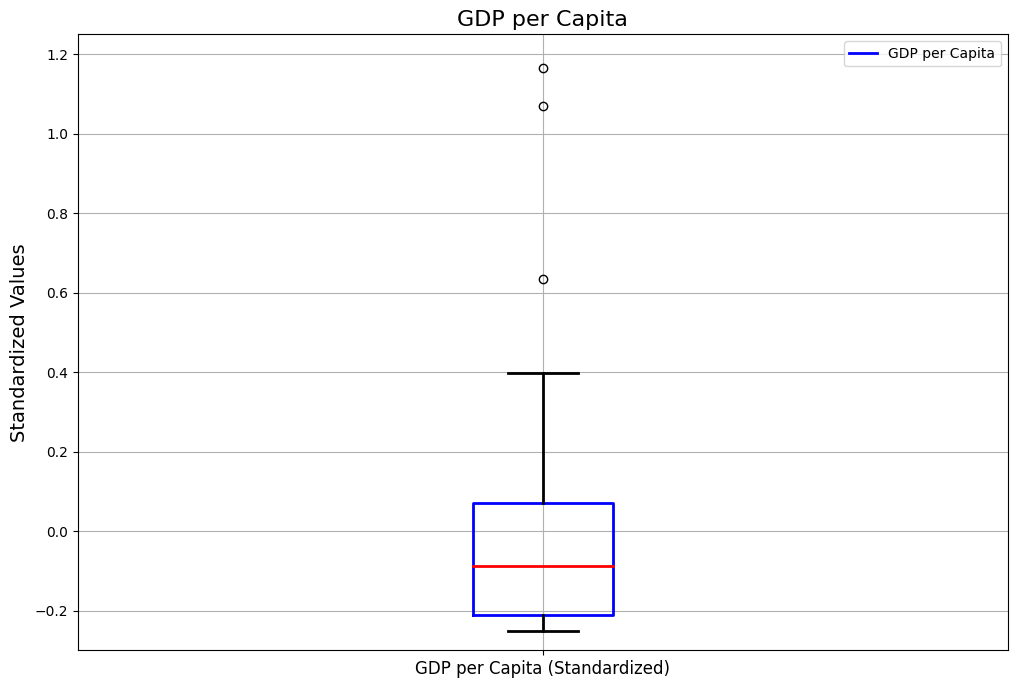

Below are outliers: 



,Country_code,gdp_capita_standard
47,BR_SP_350400,18.750615


In [44]:
# Inputting with median instead of mean because of outliers
econ_df['human_capital_index'].fillna(econ_df['human_capital_index'].median(), inplace=True)

# Scaling the GDP per capita
scaler = StandardScaler()
econ_df['gdp_capita_standard'] = scaler.fit_transform(econ_df[['gdp_per_capita_usd']])

# Drop any duplicates
econ_df.drop_duplicates(inplace=True)
econ_df = econ_df.rename(columns={'location_key': 'Country_code'})

# Creating the box-and-whisker plot for GDP per capita standardized
plt.figure(figsize=(12, 8))
boxprops = dict(linewidth=2, color='blue')
whiskerprops = dict(linewidth=2, color='black')
capprops = dict(linewidth=2, color='black')
medianprops = dict(linewidth=2, color='red')

econ_df[['gdp_capita_standard']].boxplot(
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops
)
plt.ylim(-0.3, 1.25)  # Had to adjust the y-axis to zoom in on the box properly
plt.title('GDP per Capita', fontsize=16)
plt.ylabel('Standardized Values', fontsize=14)
plt.xticks([1], ['GDP per Capita (Standardized)'], fontsize=12)
plt.grid(True)
plt.legend(['GDP per Capita'])
plt.show()

# I made this part because one outlier was so large it made the rest of the data unreadable.
# Felt it was a better choice aesthetically to limit the range of the graph to exclude it so that
#you the viewer could better see the more relevant data, but still also know the outlier value.

outliers = econ_df[econ_df['gdp_capita_standard'] > 1.5]
outliers_info = outliers[['Country_code', 'gdp_capita_standard']]

# mentioned outliers too large which cause the relevant data to become unreadable
print("Below are outliers: \n")
outliers_info

**Summary:** The box-and-whisker plot shows the distribution of GDP per capita among different countries. The median GDP per capita is around -0.1, with the interquartile range spanning from -0.2 to 0.1. The whiskers extend from -0.3 to 0.4, showing us the range of the data. A few outliers are above 0.4. One was included outside the graph so it did not make the rest of the data unreadable. This distribution suggests a large variation in GDP per capita among the countries studied, which may impact their ability to mitigate Covid properly.

**Plot 2: Bar Graph of COVID-19 Cases by Age Group**

This Bar Graph shows the distribution of Covid cases across different age groups. This helps us understand which age groups were most affected by it.

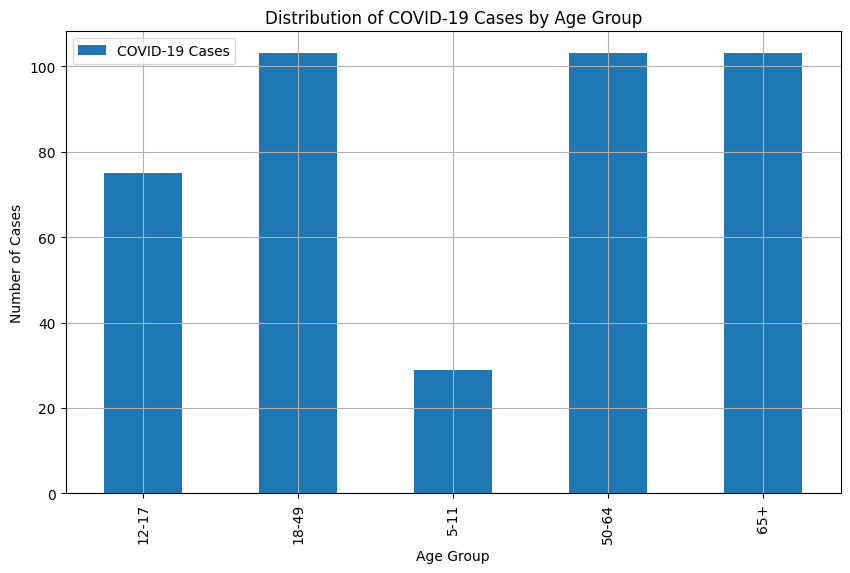

In [45]:
# Exclude 'all_ages' category
age_group_counts = covid_rates_df[covid_rates_df['age_group'] != 'all_ages']['age_group'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
age_group_counts.plot(kind='bar')
plt.xlabel('Age Group')
plt.ylabel('Number of Cases')
plt.title('Distribution of COVID-19 Cases by Age Group')
plt.legend(['COVID-19 Cases'])
plt.grid(True)
plt.show()



**Summary:** The Bar graph clearly shows that the likelihood of contracting Covid increases with age. elementary to High School ages have significantly lower cases compared to adults and the elderly, meaning that older people are at a greater risk of contracting the disease. This explains the urgency and emphasis on protecting the elderly in the peak stages of the pandemic.

**Plot 3: Pie Chart of Covid Cases by Gender**

This pie chart shows the proportion of Covid cases between males and females. This helps us see the gender distribution of Covid cases.

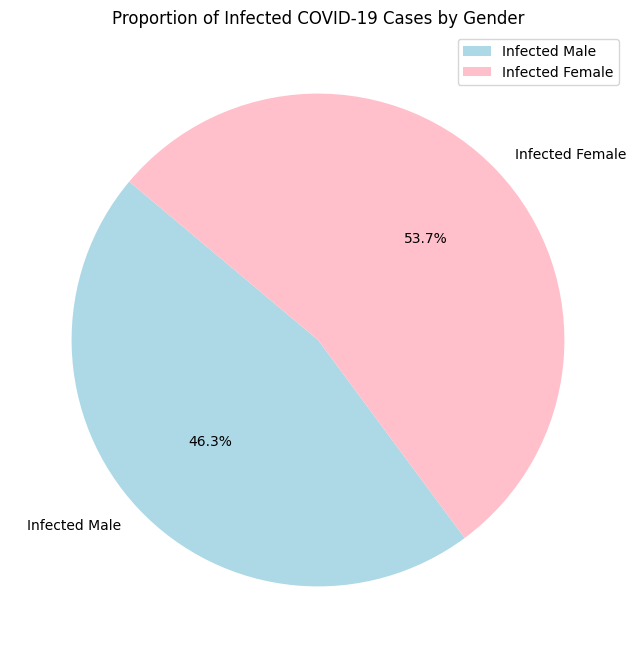

In [46]:
# Creating a DataFrame for the chart
sex_plot_df = pd.DataFrame({
    'Gender': ['Male', 'Female'],
    'Category': ['Infected', 'Infected'],
    'Count': [
        covid_sex_df['cumulative_confirmed_male'].max(),
        covid_sex_df['cumulative_confirmed_female'].max()
    ]
})

# Summing counts for infected by gender
infected_male = sex_plot_df[(sex_plot_df['Gender'] == 'Male') & (sex_plot_df['Category'] == 'Infected')]['Count'].sum()
infected_female = sex_plot_df[(sex_plot_df['Gender'] == 'Female') & (sex_plot_df['Category'] == 'Infected')]['Count'].sum()

#creating labels and their respective colors
gender_counts = [infected_male, infected_female]
labels = ['Infected Male', 'Infected Female']
colors = ['lightblue', 'pink']

#plotting
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Infected COVID-19 Cases by Gender')
plt.legend(labels)
plt.show()

**Summary:** The pie chart shows the gender distribution of the cases. Infected females account for 53.7% of the cases. Infected males constitute 46.3% of the cases. This means that the relatively similar percentages of infected males and females suggest that gender does not play a significant role in the likelihood of contracting the virus. Especially when the world population contains a higher percentage of women, one should expect a slightly higher population of women effected if both are equally affected by it.

### **OVERALL CONCLUSION**
In this project, we explored the economic and demographic factors influencing Covid contraction rates. Through the visualizations, we observed several important Patterns in our data:

**Economic Diversity and Covid Management:**
The box-and-whisker plot of GDP per capita showed a good variation among the countries. Countries with higher GDP per capita are likely to have more resources for healthcare and pandemic response, potentially leading to better control of Covid cases. This was clear in the plot's distribution and outliers.

**Age Group and Covid Contraction Rates:**
The histogram of Covid cases by age group clearly showed that older individuals have higher risk of contracting Covid. This highlights the importance of targeting older age groups with preventive measures and vaccination programs, which was emphasized during the pandemic.

**Gender Distribution of Covid Cases:**
The pie chart showed a mostly balanced distribution of Covid cases between males and females, with no significant gender bias in infection rates. This suggests that gender is likely not a critical factor in the likelihood of contracting Covid.

These insights are vital and valuable information for policymakers and health organizations in developing targeted strategies to manage and mitigate the impact of Covid. By understanding the economic and demographic factors at play, better resource allocation and preventive measures can be implemented to control the spread of the virus effectively. Especially now when the virus is not as threatening as before.

### **MACHINE LEARNING**

In [47]:
covid_rates_df['outcome_encoded'] = covid_rates_df['outcome'].apply(lambda x: 1 if x == 'death' else 0)

# Standardize the features
scaler = StandardScaler()
X = covid_rates_df[ ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir', 'crude_booster_irr', 'crude_irr']]
X = scaler.fit_transform(X)
y = covid_rates_df['outcome_encoded']
#Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


#Logistic Regression
print("Logistic Regression")
log = LogisticRegression(random_state=42)
log.fit(X_train, y_train)

# Evaluate the model
y_pred = log.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Cross-Validation Scores:",  cross_val_score(log, X, y))
print("Mean Cross-Validation Score:", np.mean(cross_val_score(log, X, y)))


Logistic Regression
[[81  4]
 [ 0 80]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        85
           1       0.95      1.00      0.98        80

    accuracy                           0.98       165
   macro avg       0.98      0.98      0.98       165
weighted avg       0.98      0.98      0.98       165

Cross-Validation Scores: [0.74545455 1.         0.8        1.         1.        ]
Mean Cross-Validation Score: 0.9090909090909092


**Conclusion** The confusion matrix shows that there are 81 True Negatives, 4 False Postives, 0 False Negatives, and 80 True positives, indicating the model to be successful in identifying between a death or a case. The classification report having values close to 1 show the models performance to be accurate with its predictions as well. The cross validation having an average of 0.9 demonstrates the models generalized accuract with some variability.

The first booster shot was made available in September of 2021. Contractions followed a similar trend for both unvaccinated and boosted populations. However, the average rate for the boosted populations were consistently lower, especially during infection spikes.

### **EVALUATION CONCLUSION**

There is a clear relation between the GDP per capita of a nation and the accumulated cases. Several outliers can be noted between the middle and high income categories, but this ultimately doesn't affect the alternative hypothesis. The booster has also has a clear impact on reducing COVID deaths, while there also seems to be a discrepancy between the sexes. Richer nations would have better access to primary vaccines and boosters which would explain their much lower death rate.

### **FINAL INSIGHTS AND CONCLUSIONS**

Based on our findings through this process, we can conclude that:

1. GDP had significant impact on contraction rates.

2. The older the person the higher chance they had of contracting the virus.

3. Sex had no real or significant effect on contraction rates.

4. The vaccine and then the booster signifcantly reduced the rates of contraction.


We can use this knowledge to help show policy makers and healthcare professionals the effectiveness of the vaccine and booster, along with how different conditions (age, sex, GDP) effect the contraction rates and target those who may have higher rates, and stop prioritizing in areas thatshow no real concern like you shouldn't prioritize one sex over the other, but getting the elderly and older individuals taken care of is important.

We hope that through this process of following the Data Science Workflow you now see how to leverage its various stages and components to clean, read, understand, and present data in a precise and insightful format.
